In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
from models import SimVP_Model
from API.dataloader_s4a import NpyPADDataset
from API.dataloader_moving_mnist import MovingMNIST

In [37]:
SELECTED_CLASSES = [
    110,   # 'Wheat'
    120,   # 'Maize'
    140,   # 'Sorghum'
    150,   # 'Barley'
    160,   # 'Rye'
    170,   # 'Oats'
    330,   # 'Grapes'
    435,   # 'Rapeseed'
    438,   # 'Sunflower'
    510,   # 'Potatoes'
    770,   # 'Peas'
]

LINEAR_ENCODER = {val: i + 1 for i, val in enumerate(sorted(SELECTED_CLASSES))}
LINEAR_ENCODER[0] = 0

def min_max_normalize(image, percentile=2):
    image = image.astype('float32')

    percent_min = np.percentile(image, percentile, axis=(0,1))
    percent_max = np.percentile(image, 100-percentile, axis=(0,1))

    mask = np.mean(image, axis=2) != 0
    if image.shape[1] * image.shape[0] - np.sum(mask) > 0:
        mdata = np.ma.masked_equal(image, 0, copy=False)
        mdata = np.ma.filled(mdata, np.nan)
        percent_min = np.nanpercentile(mdata, percentile, axis=(0, 1))

    norm = (image-percent_min) / (percent_max - percent_min)
    norm[norm<0] = 0
    norm[norm>1] = 1
    norm = (norm * 255).astype('uint8') * mask[:,:,np.newaxis]

    return norm
def nanmin(batch, ann, label=981):
    batch = batch.astype('float32')
    mask = ann == 981
    batch = batch * ann[np.newaxis, np.newaxis, ...]
    batch[batch == 0.] = np.nan
    
    mean = np.nanmean(batch, axis=(2,3))
    return mean

def ndvi(arr):
    nir = arr[...,3]
    red = arr[...,2]
    ndvi = (nir-red)/(nir+red + 1e-2)
    return ndvi

In [3]:
rootdir = '/home/jovyan/Desktop/SimVPv2/results/Debug/checkpoints'
listdir = os.listdir(rootdir)
print(listdir)

['s4a_expelriment_1500.pth', 's4a_expelriment_6000.pth', 's4a_expelriment_2500.pth', 's4a_expelriment_500.pth', 's4a_expelriment_3500.pkl', 's4a_expelriment_7500.pkl', 's4a_expelriment_0.pth', 's4a_expelriment_5000.pkl', 's4a_expelriment_7000.pth', 's4a_expelriment_1000.pkl', 's4a_expelriment_4000.pkl', 's4a_expelriment_3000.pkl', 's4a_expelriment_6500.pth', 's4a_expelriment_5500.pkl', 's4a_expelriment_2000.pth', 's4a_expelriment_500.pkl', 's4a_expelriment_4000.pth', 's4a_expelriment_2000.pkl', 's4a_expelriment_5500.pth', 's4a_expelriment_1500.pkl', 's4a_expelriment_6000.pkl', 's4a_expelriment_7000.pkl', 's4a_expelriment_0.pkl', 's4a_expelriment_2500.pkl', 's4a_expelriment_6500.pkl', 's4a_expelriment_7500.pth', 's4a_expelriment_5000.pth', 's4a_expelriment_4500.pkl', 's4a_expelriment_1000.pth', 's4a_expelriment_3500.pth', 's4a_expelriment_4500.pth', 's4a_expelriment_3000.pth']


In [4]:
test_set = NpyPADDataset(root_dir='/home/jovyan/shared_volume/data/newdata', band_mode='nrgb', start_month=1, end_month=13, mode='val',
                        get_ann=True)

# test_set = MovingMNIST('data', is_train=True)
dataloader_test = torch.utils.data.DataLoader(
        test_set, batch_size=1, shuffle=False, pin_memory=True, drop_last=True, num_workers=4)

Rootdir: /home/jovyan/shared_volume/data/newdata
Scenario: 1, MODE: val, length of datasets: 1000
Acquired Data Month: From 1 to 13
Data shape: [T, C, H, W] (12, 4, 64, 64)


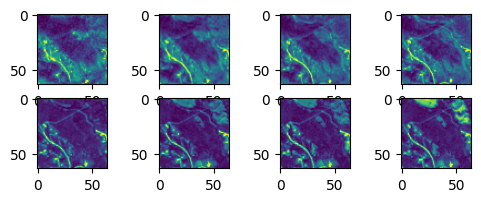

In [5]:
imgs = test_set[0][0].detach().cpu().numpy()
fig, ax = plt.subplots(2,4, figsize=(6, 2))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(imgs[i][0])
plt.show()

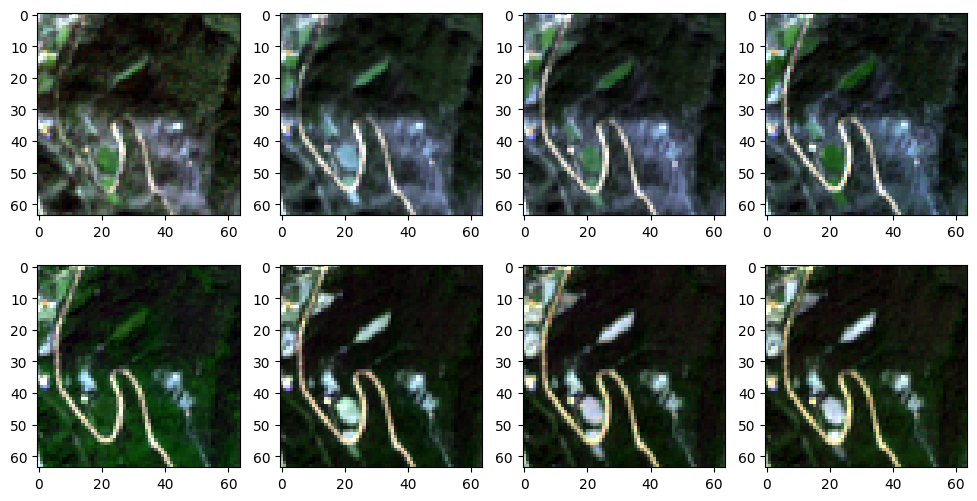

In [6]:
imgs = test_set[0][0].detach().cpu().numpy()
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax = ax.flatten()
for i in range(8):
    # ax[i].imshow(min_max_normalize(imgs[i][:3].transpose(1,2,0), percentile=0.5))
    ax[i].imshow(imgs[i][:3].transpose(1,2,0))
plt.show()

In [7]:
model = SimVP_Model(in_shape=(8,4,64,64), hid_S=64, hid_T=512, N_S=4, N_T=8, model_type='gSTA',
                   mlp_ratio=8., drop=0.0, drop_path=0.0, spatio_kernel_enc=3, spatio_kernel_dec=3, pre_seq_length=8, aft_seq_length=4)

model.load_state_dict(torch.load(os.path.join(rootdir, 's4a_expelriment_6000.pth')))
model.eval()
print('_')

_


In [48]:
for i, (batch_x, batch_y, ann) in enumerate(dataloader_test):
    if i!=13: # 9
        pass
    else:
        # batch_x, batch_y, ann = test_set[10]
        pred_y = model(batch_x)
        print(batch_x.shape, batch_y.shape, pred_y.shape, ann.shape)

        break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


torch.Size([1, 8, 4, 64, 64]) torch.Size([1, 4, 4, 64, 64]) torch.Size([1, 4, 4, 64, 64]) torch.Size([1, 64, 64])


In [55]:
batch_x = batch_x.detach().cpu().numpy()[0]
batch_y = batch_y.detach().cpu().numpy()[0]
pred_y = pred_y.detach().cpu().numpy()[0]
ann = ann.detach().cpu().numpy()[0].astype('uint8')

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [50]:
_ = np.zeros_like(ann)
for crop_id, linear_id in LINEAR_ENCODER.items():
    _[ann == crop_id] = linear_id
ann = _

# # Map all classes NOT in linear encoder's values to 0
ann[~np.isin(ann, list(LINEAR_ENCODER.values()))] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


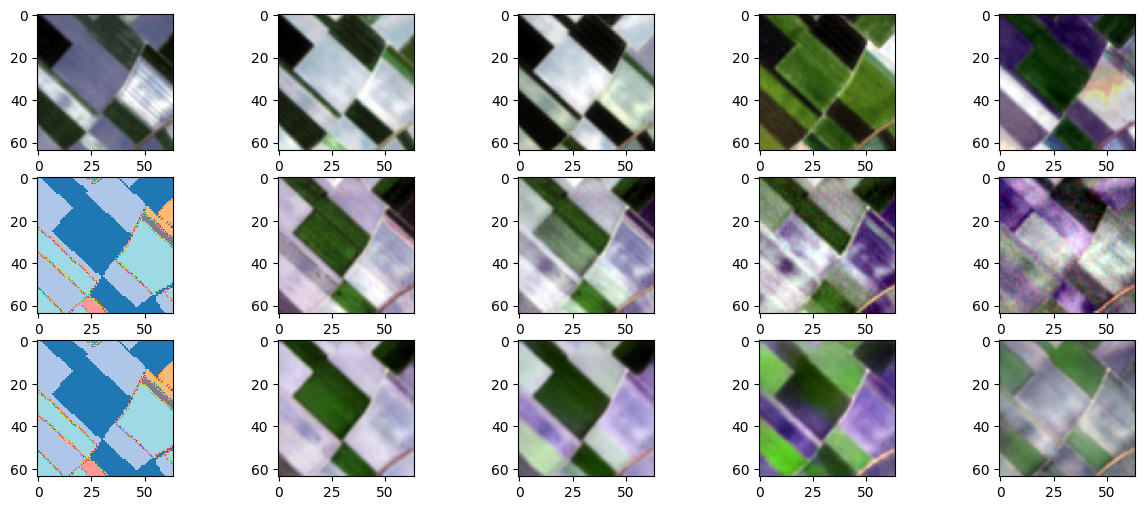

In [58]:
fig, ax = plt.subplots(3, 5, figsize=(15,6))
for i in range(5):
    ax[0][i].imshow(batch_x[i+2].transpose(1,2,0)[:,:,:3])


ax[1][0].imshow(ann, cmap='tab20')
ax[2][0].imshow(ann, cmap='tab20')
# ax[2][0].imshow(batch_x[-1].transpose(1,2,0))
for i in range(4):
    # ax[0][i].imshow(min_max_normalize(batch_y[i].transpose(1,2,0)))
    ax[1][i+1].imshow(batch_y[i].transpose(1,2,0)[:,:,:3])

for i in range(4):
    ax[2][i+1].imshow(pred_y[i].transpose(1,2,0)[:,:,:3])

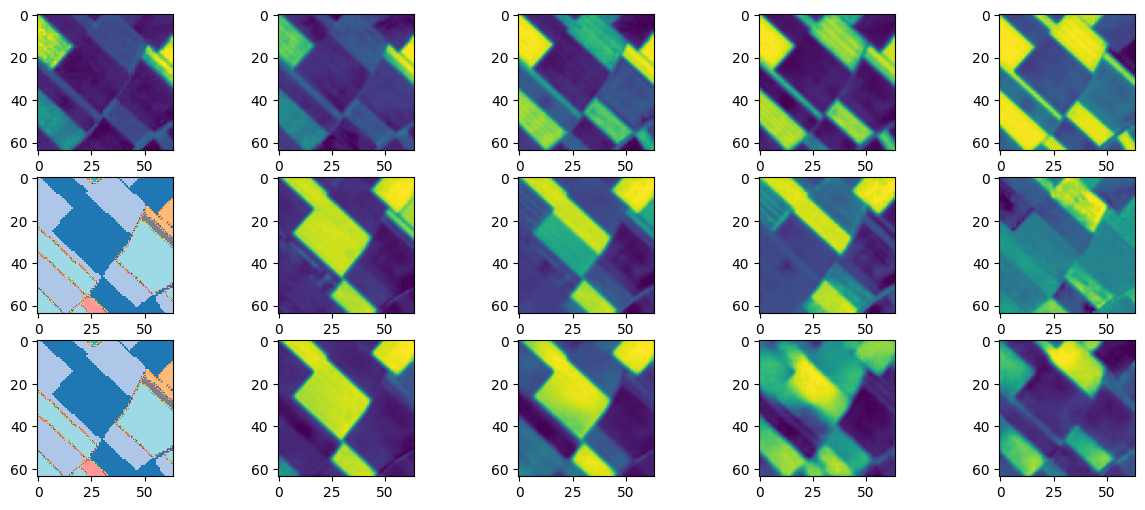

In [61]:
fig, ax = plt.subplots(3, 5, figsize=(15,6))
for i in range(5):
    ax[0][i].imshow(min_max_normalize(ndvi(batch_x[i].transpose(1,2,0))[...,np.newaxis], percentile=0.5))


ax[1][0].imshow(ann, cmap='tab20')
ax[2][0].imshow(ann, cmap='tab20')
# ax[2][0].imshow(batch_x[-1].transpose(1,2,0))
for i in range(4):
    # ax[0][i].imshow(min_max_normalize(batch_y[i].transpose(1,2,0)))
    ax[1][i+1].imshow(min_max_normalize(ndvi(batch_y[i].transpose(1,2,0))[...,np.newaxis], percentile=0.5))

for i in range(4):
    ax[2][i+1].imshow(min_max_normalize(ndvi(pred_y[i].transpose(1,2,0))[...,np.newaxis], percentile=0.5))

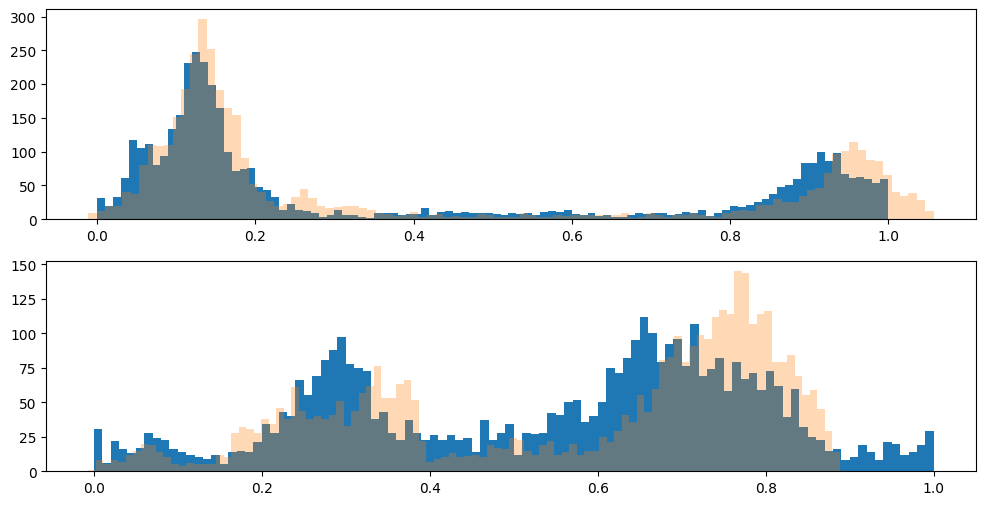

In [53]:
fig, ax = plt.subplots(2,1, figsize=(12,6))
ax[0].hist(batch_y[0][3].flatten(), bins=100, label='gt')
ax[0].hist(pred_y[0][3].flatten(), bins=100, label='pred', alpha=0.3)

ax[1].hist(batch_y[0][1].flatten(), bins=100, label='gt')
ax[1].hist(pred_y[0][1].flatten(), bins=100, label='pred', alpha=0.3)
plt.show()

In [34]:
print(np.unique(ann))
r_batch_x = nanmin(batch_x, ann, label=4)
r_batch_y = nanmin(batch_y, ann, label=4)
r_pred_y = nanmin(pred_y, ann, label=4)

[0 6]


In [35]:
X = np.concatenate([r_batch_x, r_batch_y], axis=0)
Y = np.concatenate([r_batch_x, r_pred_y], axis=0)

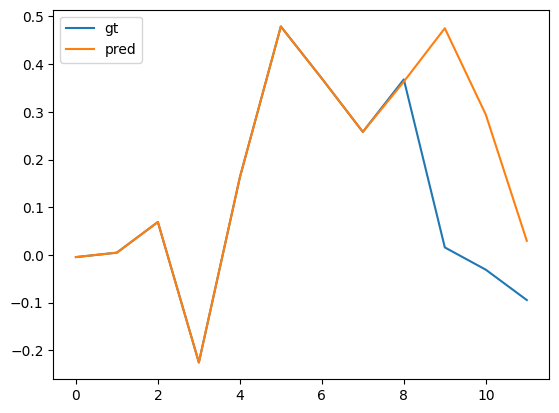

In [36]:
plt.plot(range(len(X)), ndvi(X), label='gt')
plt.plot(range(len(X)), ndvi(Y), label='pred')
plt.legend()